# Glow

Difference from RealNVP 

- Invertible 1x1 convolution
- Actnorm

## Invertible 1x1 convolution

RealNVP uses Permutation by the channel dimention for Affine Coupling Layer. (Intuitively、we want to replace $x_a$ and $x_b$, I think...)

In Glow, the Permutaion is changed to the Invertible 1x1 convolution he proposed. It's a learnable layer (bijector).

formula

1. forward function
2. reverse function
3. log determinant

## Actnorm
Instead of Batch Normalization

Week points of Batch Normalization
1. IF batch size is small, it may decrease performance. (In flow base model, Batch size is often too small since this model needs large memory...)


Behavior of Actnorm
1. normalize by **channel-wise** , using the **first batch**
2. initialize weights by the normalize parameter. (bias and scale)
3. learn these weights since next batch.

# Problem Setting
Multivariate normal distribution $\leftrightarrow$ MNIST dataset

# Use Tensorflow
## Implementation Plan
0. Preprocess
1. Create Dataset
2. Build Multi-Scale Model
    1. Invertible 1x1 convolution Bijector
    2. Actnorm Bijector
    3. Multi-Scale Model
4. Build モデル
    1. TransformDistribution
    2. Loss, Optimizar
    3. Training
    4. Inference

## Preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.0.0-rc0
tensorflow-probability:  0.8.0-rc0


## Create Dataset
ref. [realnvp's tutorial](./RealNVP_mnist_en.ipynb)

### Create Target Distibution ($z$)
In this part, use Multivariate normal distribution

In [2]:
# Tensorflow の distribution を使う場合
z = tf.random.normal([2, 2, 256])
print('Tensorflow             : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))
# Tensorflow Probability の distribution を使う場合
target_dist = tfd.Normal(loc=0., scale=1.)
z = target_dist.sample([2, 2, 256])
print('Tensorflow Probability : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))

Tensorflow             : shape: (2, 2, 256) mean: -0.016205 sd: 0.978316
Tensorflow Probability : shape: (2, 2, 256) mean: 0.039007 sd: 0.966307


### Create Original Distribution (MNIST)

In [3]:
feature_description  = {
    'img': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

def _parse_function(example_proto):
    feature = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_raw(feature['img'], out_type=tf.uint8)
    img = tf.reshape(img, [32, 32, 1])
    img = tf.cast(img, dtype=tf.float32)
    img = (img / (255.0 / 2)) - 1
    feature['img'] = img
    return feature

In [4]:
import os

SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

filenames = [os.path.join('mnists', 'train.tfrecord')]
raw_dataset = tf.data.TFRecordDataset(filenames)
print(raw_dataset)
parsed_dataset = raw_dataset.map(_parse_function) 
print(parsed_dataset)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<MapDataset shapes: {img: (32, 32, 1), label: ()}, types: {img: tf.float32, label: tf.int64}>


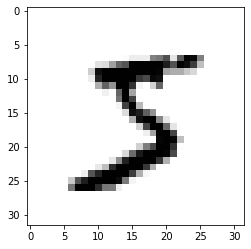

In [5]:
for image_features in parsed_dataset.take(1):
    plt.imshow(tf.squeeze(image_features['img'], axis=-1), cmap='gray_r')

## Build Multi-Scale Model

### Invertive 1x1 convolution Bijector
ref. 
- Tensorflow Probability's implementation tensorflow_probability/bijector/MatvecLU 
- the issue https://github.com/tensorflow/probability/issues/545 

In [6]:
def trainable_lu_factorization(event_size,
                               batch_shape=(),
                               seed=None,
                               dtype=tf.float32,
                               name=None):
    with tf.name_scope('trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(event_size,
                                          dtype=tf.int32,
                                          name='event_size')
        batch_shape = tf.convert_to_tensor(batch_shape,
                                           dtype=event_size.dtype,
                                           name='batch_shape')
        random_matrix = tf.Variable(tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed,
        ),
                                    name='conv1x1_weights')

        def lu_p(m):
            return tf.linalg.lu(tf.linalg.qr(m).q)

        # lower_upper = tfp.util.DeferredTensor(lambda m: lu_p(m)[0],
        #                                       random_matrix)
        # permutation = tfp.util.DeferredTensor(lambda m: lu_p(m)[1],
        #                                       random_matrix,
        #                                       # trainable=False,
        #                                       dtype=tf.int32,
        #                                       shape=random_matrix.shape[:-1])
        lower_upper = tf.Variable(lu_p(random_matrix)[0], name='lower_upper')
        # ref https://github.com/tensorflow/probability/issues/545
        permutation = tf.Variable(lu_p(random_matrix)[1], trainable=False, name='permutation')
        return lower_upper, permutation


def build_model(channels=3):
    # conv1x1 setup
    t_lower_upper, t_permutation = trainable_lu_factorization(channels)
    conv1x1 = tfb.MatvecLU(t_lower_upper, t_permutation, name='MatvecLU')
    print('conv1x1 variable\n', conv1x1.variables)
    inv_conv1x1 = tfb.Invert(conv1x1)

    # forward setup
    fwd = tfp.layers.DistributionLambda(
        lambda x: conv1x1(tfd.Deterministic(x)))
    fwd.vars = conv1x1.trainable_variables

    # inverse setup
    inv = tfp.layers.DistributionLambda(
        lambda x: inv_conv1x1(tfd.Deterministic(x)))
    inv.vars = inv_conv1x1.trainable_variables
    
    x: tf.Tensor = tf.keras.Input(shape=[28, 28, channels])
    fwd_x: tfp.distributions.TransformedDistribution = fwd(x)
    rev_fwd_x: tfp.distributions.TransformedDistribution = inv(fwd_x)
    example_model = tf.keras.Model(inputs=x, outputs=rev_fwd_x, name='conv1x1')
    return example_model


def test_conv1x1():
    example_model = build_model()
    example_model.trainable = True
    example_model.summary()

    real_x = tf.random.uniform(shape=[2, 28, 28, 3], dtype=tf.float32)
    if example_model.weights == []:
        print('No Trainable Variable exists')
    else:
        print('Some Trainable Variables exist')

    with tf.GradientTape() as tape:
        tape.watch(real_x)
        out_x = example_model(real_x)
        out_x = out_x
        loss = out_x - real_x
    print(tf.math.reduce_sum(real_x - out_x))
    # => nealy 0
    # ex. tf.Tensor(1.3522818e-05, shape=(), dtype=float32)

    try:
        print(tape.gradient(loss, real_x).shape)
    except Exception as e:
        print('Cannot Calculate Gradient')
        print(e)
        
test_conv1x1()

conv1x1 variable
 (<tf.Variable 'trainable_lu_factorization/lower_upper:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.59477895, -0.3432535 ,  0.72692156],
       [ 0.99011046,  1.1414331 , -0.8230729 ],
       [ 0.9200218 , -0.15221724, -1.4729699 ]], dtype=float32)>, <tf.Variable 'trainable_lu_factorization/permutation:0' shape=(3,) dtype=int32, numpy=array([1, 2, 0], dtype=int32)>)
Model: "conv1x1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
distribution_lambda (Distrib ((None, 28, 28, 3), (None 9         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 28, 28, 3), (None 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Some 

### Actnorm Bijector
Notice: Initialize by the **First Batch**

※ By the way, Actnorm implementation by OpenAI https://github.com/openai/glow/blob/master/tfops.py#L71-L87　is not same as their paper's formula, I think...     
Forward's formula may be $(x + b) \odot s$ ...

In [7]:
class Actnorm(tfb.Bijector):
    def __init__(self, channels:int, validate_args=False, name='actnorm', log_scale_factor=1.0):
        super(Actnorm, self).__init__(
            # this bijector affect vector-wise (channel-wise) => forward_min_event_ndims=1
            forward_min_event_ndims=1,
            validate_args=validate_args,
            name=name
        )
        self.log_scale_factor = log_scale_factor
        self.initialized = False
        self.log_scale = tf.Variable(tf.random.normal([channels]))
        self.bias = tf.Variable(tf.random.normal([channels]))
        
    def setStat(self, x):
        mean = tf.math.reduce_mean(x, axis=[0, 1, 2])
        var = tf.math.reduce_mean((x - mean) ** 2, axis=[0, 1, 2])
        stdvar = tf.math.sqrt(var) + 1e-6
        log_scale = tf.math.log(1./ stdvar / self.log_scale_factor) * self.log_scale_factor
        self.bias.assign(- mean)
        self.log_scale.assign(log_scale)

    def _forward(self, x):
        if not self.initialized:
            self.setStat(x)
            self.initialized = True
        return (x + self.bias) * tf.exp(self.log_scale)
    
    def _inverse(self, y):
        if not self.initialized:
            self.setStat(y)
            self.initialized = True
        return y * tf.exp(- self.log_scale) - self.bias
    
    def _forward_log_det_jacobian(self, x):
        return tf.reduce_sum(self.log_scale)

    def _inverse_log_det_jacobian(self, y):
        return - tf.reduce_sum(self.log_scale)
    
def test_actnorm():
    actnorm = Actnorm(4)
    x = tf.random.normal([100, 16, 16, 4]) + 100
    y = actnorm.forward(x)
    z = actnorm.inverse(y)
    print('input: x', tf.reduce_mean(x, axis=[0, 1, 2]).numpy())
    print('output: y', tf.reduce_mean(y, axis=[0, 1, 2]).numpy())
    print('inverse: z', tf.reduce_mean(z, axis=[0, 1, 2]).numpy())
    print('log_det_jacobian: ', actnorm.forward_log_det_jacobian(y, event_ndims=3).numpy())

test_actnorm()

input: x [ 99.99293  100.00224   99.998405  99.998146]
output: y [-4.3174623e-06 -3.9696693e-07  2.7258693e-06 -8.9507548e-06]
inverse: z [ 99.99293  100.00224   99.998405  99.998146]
log_det_jacobian:  0.309142


### Multi-Scale Model
Implement blueprint    
![](./multi-scale-arch.png)

In [1]:
# ref RealNVP_mnist_en.ipynb
from bijectors import squeeze3d
from bijectors import affineCoupling
from bijectors import blockwise3d
Squeeze3D = squeeze3d.Squeeze3D
NN = affineCoupling.NN
RealNVP = affineCoupling.RealNVP
Blockwise3D = blockwise3d.Blockwise3D

In [9]:
def gen_flowSteps(
    # for realnvp
    input_shape: list,
    n_hidden: list = [128, 128],
    # for flowStep
    k=4,
    forward_min_event_ndims: int = 3,
    validate_args: bool = False,
    name: str = "flow_step",
):
    flow_step_list = []
    for i in range(k):
        t_lower_upper, t_permutation = trainable_lu_factorization(input_shape[-1])
        # TODO: if include this actnorm in my model, loss is to be NaN ... 
        flow_step_list.append(Actnorm(input_shape[-1]))
        flow_step_list.append(
            tfb.MatvecLU(
                t_lower_upper, t_permutation, name="{}_{}/matveclu".format(name, i)
            )
        ),
        flow_step_list.append(
            RealNVP(
                input_shape=input_shape,
                n_hidden=n_hidden,
                validate_args=validate_args,
                name="{}_{}/realnvp".format(name, i),
            )
        )

    flowSteps = tfb.Chain(
        list(reversed(flow_step_list)), validate_args=validate_args, name=name
    )
    return flowSteps


def test_gen_flowSteps():
    flowSteps = gen_flowSteps(
        k=2, input_shape=[16, 16, 4], forward_min_event_ndims=0, name="flowstep_0"
    )
    x = tf.keras.Input([16, 16, 4])
    y = flowSteps(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([6, 16, 16, 4])
    y = flowSteps.forward(x)
    z = flowSteps.inverse(y)
    return tf.reduce_sum(z - x)


test_gen_flowSteps()

<tf.Tensor: id=1761, shape=(), dtype=float32, numpy=0.0>

In [10]:
def gen_flow(input_shape, level=3, flow_step_args: dict = None):
    def _gen_input_shapes(input_shape, level):
        input_shape = input_shape
        input_shapes = []
        for i in range(level):
            input_shape = [
                input_shape[0] // 2,
                input_shape[1] // 2,
                input_shape[2] * 4 - i * 8,
            ]
            input_shapes.append(input_shape)
        return input_shapes

    input_shapes = _gen_input_shapes(input_shape, level)

    def _add_flow(_input_shapes, flow_step_args):
        flow_lists = []
        flow_lists.append(
            Squeeze3D(name="Squeeze_{}".format(level - len(_input_shapes)))
        )
        flowSteps = gen_flowSteps(
           k=2,
           input_shape=_input_shapes[0],
           name="Flowsteps_{}".format(level - len(_input_shapes)),
        )
        flow_lists.append(flowSteps)
        if len(_input_shapes) != 1:
            flow_lists.append(
                Blockwise3D(
                    [
                        tfb.Identity(),
                        tfb.Chain(
                            list(reversed(_add_flow(_input_shapes[1:], flow_step_args)))
                        ),
                    ],
                    name="Blockwise3D_{}".format(level - len(_input_shapes)),
                )
            )
        flow_lists.append(
            tfb.Invert(
                Squeeze3D(name="Unsqueeze_{}".format(level - len(_input_shapes)))
            )
        )
        return flow_lists

    return tfb.Chain(list(reversed(_add_flow(input_shapes, level))))


def test_gen_flow():
    flow = gen_flow([32, 32, 1])
    print(len(flow.trainable_variables))
    x = tf.keras.Input([32, 32, 1])
    y = flow.forward(x)
    # tf.keras.Model(x, y).summary()
    tf.keras.utils.plot_model(
        tf.keras.Model(x, y), show_shapes=True, to_file="realnvp.png"
    )
    x = tf.random.normal([3, 32, 32, 1])
    y = flow.forward(x)
    z = flow.inverse(y) 
    return tf.reduce_sum(z - x)

test_gen_flow()

66


<tf.Tensor: id=4611, shape=(), dtype=float32, numpy=0.0>

## Build Model

### TransformDistribution

In [24]:
flow_bijector = gen_flow([32, 32, 1], level=3)
print(len(flow_bijector.trainable_variables))
flow = tfd.TransformedDistribution(
    event_shape =[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=flow_bijector
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

66
trainable_variables:  66


### Loss, Optimizer

In [26]:
!rm -r checkpoints

rm: 'checkpoints' を削除できません: そのようなファイルやディレクトリはありません


In [27]:
@tf.function
def loss():
    return - tf.reduce_mean(flow.log_prob(targets['img']))


optimizer = tf.optimizers.Adam(learning_rate=1e-4) 
log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [46]:
BATCH_SIZE=120
train_dataset = parsed_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
for target in train_dataset.take(1):
    targets = target
print(targets['img'].shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, flow.trainable_variables)
print(log_prob_loss)

(120, 32, 32, 1)
tf.Tensor(14203124000000.0, shape=(), dtype=float32)


### Training

In [47]:
n_epochs = 30

flag = False
for epoch in range(n_epochs):
    if flag:
        print('raise NaN')
        break
    for targets in train_dataset:
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        if tf.math.is_nan(log_prob_loss):
            flag=True
            break
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 1000, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
        if tf.equal(optimizer.iterations % 100, 0):
            with log.as_default():
                tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
                avg_loss.reset_states()

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss 542264.750000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2000> Loss 79614.140625
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=3000> Loss 33209.816406
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=4000> Loss 13674.369141
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=5000> Loss -8822.915039
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=6000> Loss -47744.031250
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=7000> Loss -74261.812500
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=8000> Loss -95357.031250
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=9000> Loss -118151.429688
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=10000> Loss -138773.843750
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=11000> Loss -154746.093750
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1200

### Inference

In [284]:
filenames = [os.path.join('mnists', 'test.tfrecord')]
test_raw_dataset = tf.data.TFRecordDataset(filenames)
test_parsed_dataset = test_raw_dataset.map(_parse_function) 
test_dataset = test_parsed_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

log probability:  -24.176485
inv mean:  -0.09408589  std:  6.819548
re:trg mean:  -0.80294776  std:  0.54607326
(1, 32, 32, 1)


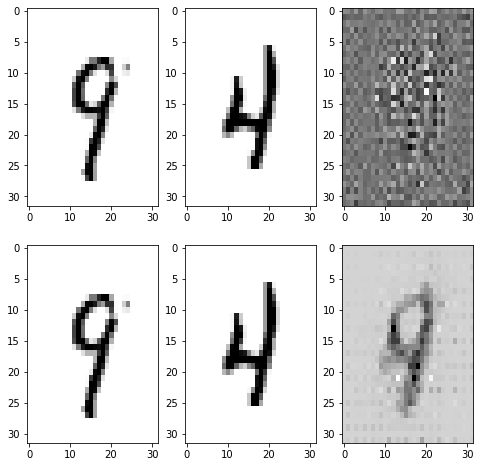

In [60]:
fig = plt.figure(figsize=(8, 8))
for targets in test_dataset.take(1):
    trg = targets["img"]
    inv = flow.bijector.inverse(trg)
    re_trg = flow.bijector.forward(inv)

print('log probability: ', tf.reduce_mean(tfd.Normal(0., 1.).log_prob(inv)).numpy())
print("inv mean: ", tf.reduce_mean(inv).numpy(), " std: ", tf.math.reduce_std(inv).numpy())
print("re:trg mean: ", tf.reduce_mean(re_trg).numpy(), " std: ", tf.math.reduce_std(re_trg).numpy())

re_inv = np.array([(inv[0] + inv[1]) / 2.0])
print(re_inv.shape)
re_re_trg = flow.bijector.forward(re_inv)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(tf.squeeze(trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 4)
ax.imshow(tf.squeeze(re_trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 2)
ax.imshow(tf.squeeze(trg[1], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 5)
ax.imshow(tf.squeeze(re_trg[1], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 3)
ax.imshow(tf.squeeze(re_inv[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 6)
ax.imshow(tf.squeeze(re_re_trg[0], axis=-1), aspect="auto", cmap="gray_r")